# **Project - Deep Learning**
### **Ghazanfar Ali (FA19-MSCS-0016)**
### **Ghulam Abbas (FA19-MSCS-0034)**

# **To Download Data Set**

* https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
* https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

# **1- Importing Necessaries Libraries**

In [1]:
from os import listdir
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
from pickle import dump, load
import tensorflow

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model

from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu

# # small library for seeing the progress of loops.
# from tqdm import tqdm_notebook as tqdm
# tqdm().pandas()

# **2- Setting Directory Path**

In [4]:
root_dir = '/content/drive/MyDrive/MAJU/DL/Project/'
print(root_dir)

flicker8k_text = root_dir + 'Flicker8k_text/'
flicker8k_dataset = root_dir + 'Flicker8k_Dataset/'

print(flicker8k_text)
print(flicker8k_dataset)

/content/drive/MyDrive/MAJU/DL/Project/
/content/drive/MyDrive/MAJU/DL/Project/Flicker8k_text/
/content/drive/MyDrive/MAJU/DL/Project/Flicker8k_Dataset/


In [5]:
my_proj_dir = '/content/drive/MyDrive/MAJU/DL/Project/My Image Captioning Project/'
print(my_proj_dir)

/content/drive/MyDrive/MAJU/DL/Project/My Image Captioning Project/


# **3- Understatnding the Data**

In [4]:
def load_doc(filename):
	file = open(filename, 'r')    	# open the file as read only
	text = file.read()              # read all text
	file.close()
	return text

In [5]:
print(listdir(flicker8k_text))

['Flickr8k.lemma.token.txt', 'Flickr_8k.trainImages.txt', 'Flickr_8k.testImages.txt', 'Flickr_8k.devImages.txt', 'ExpertAnnotations.txt', 'CrowdFlowerAnnotations.txt', 'readme.txt', 'Flickr8k.token.txt']


In [6]:
flicker_token_txt = load_doc(flicker8k_text+'Flickr8k.token.txt')


In [7]:
print(flicker_token_txt[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [8]:
def make_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [9]:
df = make_dataset(flicker_token_txt)
df[:10]

[['1000268201_693b08cb0e.jpg',
  '0',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', '1', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  '2',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '3',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '4',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg',
  '0',
  'a black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  '1',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '2',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  '3',
  'two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '4',
  'two dogs on pavement moving t

In [10]:
data = pd.DataFrame(df,columns=["filename","caption #","caption"])
# Reordering columns for better readability
# data = data.reindex(columns =['index','filename','caption'])
data

,filename,caption #,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


# **4- Data Preprocessing**

In [11]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [12]:
print(flicker8k_text+'Flickr8k.token.txt')

/content/drive/MyDrive/MAJU/DL/Project/Flicker8k_text/Flickr8k.token.txt


In [13]:
descriptions = all_img_captions(flicker8k_text+'Flickr8k.token.txt')
print("Length of descriptions =" ,len(descriptions))


Length of descriptions = 8092


In [14]:
list(descriptions.items())[:4]


[('1000268201_693b08cb0e.jpg',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']),
 ('1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'A black dog and a tri-colored dog playing with each other on the road .',
   'A black dog and a white dog with brown spots are staring at each other in the street .',
   'Two dogs of different breeds looking at each other on the road .',
   'Two dogs on pavement moving toward each other .']),
 ('1002674143_1b742ab4b8.jpg',
  ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
   'A little girl is sitting in front of a large painted rainbow .',
   'A small girl in the grass plays with fingerpaints in front of a white canvas with a r


* In Python3, string.punctuation is a pre-initialized string used as string constant. 
* In Python, string.punctuation will give the all sets of punctuation.



In [15]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            desc = [word.lower() for word in desc]                            #converts to lower case
            desc = [word.translate(table) for word in desc]                   #remove punctuation from each token
            desc = [word for word in desc if(len(word)>1)]                    #remove hanging 's and a 
            desc = [word for word in desc if(word.isalpha())]                 #remove tokens with numbers in them

            img_caption = ' '.join(desc)                                      #convert back to string
            captions[img][i]= img_caption
    return captions

In [16]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)


In [17]:
print(len(clean_descriptions))

8092


In [18]:
list(clean_descriptions.items())[:4]


[('1000268201_693b08cb0e.jpg',
  ['child in pink dress is climbing up set of stairs in an entry way',
   'girl going into wooden building',
   'little girl climbing into wooden playhouse',
   'little girl climbing the stairs to her playhouse',
   'little girl in pink dress going into wooden cabin']),
 ('1001773457_577c3a7d70.jpg',
  ['black dog and spotted dog are fighting',
   'black dog and tricolored dog playing with each other on the road',
   'black dog and white dog with brown spots are staring at each other in the street',
   'two dogs of different breeds looking at each other on the road',
   'two dogs on pavement moving toward each other']),
 ('1002674143_1b742ab4b8.jpg',
  ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
   'little girl is sitting in front of large painted rainbow',
   'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
   'there is girl with pigtails sitting in front of rainbo

In [19]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [20]:
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [21]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        key = str(key.split('.')[0])
        for desc in desc_list:
            lines.append(key + ' ' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
#saving each description to file 
save_descriptions(clean_descriptions, my_proj_dir + "descriptions.txt")

# **5- Extracting Features**

## **5.1- VGG16**

In [22]:
# extract features from each photo in the directory using VGG16

def extract_features_vgg16(directory):
  model = VGG16()                 	                                            # load the model
  model.layers.pop()                	                                          # re-structure the model
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  print(model.summary())
  features = dict()                                                             # extract features from each photo
  for name in listdir(directory):
    filename = directory + '/' + name                                           # load an image from file
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # reshape data for the model
    image = preprocess_input(image)         		                                # prepare the image for the VGG model
    feature = model.predict(image, verbose=0) 		                              # get features
    image_id = name.split('.')[0]             		                              # get image id
    features[image_id] = feature                  		                          # store feature
    print('>%s' % name)
  return features

* Extract features from all images using VGG16
* If feature not extracted --> Run next cell (Take too long time)
  * & save features as: features_vgg16.pkl

* If feature already extracted --> load features from (features_vgg16.pkl)


In [ ]:
# features_vgg16 = extract_features_vgg16(flicker8k_dataset)

Streaming output truncated to the last 5000 lines.
>2633722629_5eeb649c09.jpg
>1235681222_819231767a.jpg
>2094810449_f8df9dcdf7.jpg
>3030566410_393c36a6c5.jpg
>2263655670_517890f5b7.jpg
>2715035273_8fc8b1291c.jpg
>256292144_b53aadae27.jpg
>2402793046_3385554e81.jpg
>2715337869_e4fe36db50.jpg
>3616808182_fb4eaec778.jpg
>3487015378_2e90a79f4b.jpg
>260231029_966e2f1727.jpg
>483039719_75181b2726.jpg
>2195887578_3ba2f29b48.jpg
>3476381830_3751dd9339.jpg
>3665169936_01ae94c9fd.jpg
>2855667597_bf6ceaef8e.jpg
>471402959_0b187560df.jpg
>502115726_927dd684d3.jpg
>3490186050_4cb4193d4d.jpg
>3640329164_20cb245fd5.jpg
>3415003392_139c0f3586.jpg
>268654674_d29e00b3d0.jpg
>3616771728_2c16bf8d85.jpg
>3580375310_46ec3e476c.jpg
>2714878018_1593c38d69.jpg
>2876993733_cb26107d18.jpg
>408573233_1fff966798.jpg
>2787868417_810985234d.jpg
>2456907314_49bc4591c4.jpg
>3119887391_212f379797.jpg
>3159995270_17334ccb5b.jpg
>2880051254_e0ca96b6be.jpg
>3372215826_b3e6403b2e.jpg
>263850317_5bb3a18a08.jpg
>221973402_e

In [ ]:
# dump(features_vgg16, open(my_proj_dir + 'features_vgg16.pkl', 'wb'))

In [23]:
features_vgg16 = load(open(my_proj_dir + "features_vgg16.pkl","rb"))


In [24]:
print("Type of features: ", type(features_vgg16))
print('Extracted Features: %d' % len(features_vgg16))

Type of features:  <class 'dict'>
Extracted Features: 8127


# **6- Loading Dataset of Images for Training**

In [25]:
# load a pre-defined list of photo identifiers

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:     		                # skip empty lines      
			continue
		identifier = line.split('.')[0]       		# get the image identifier
		dataset.append(identifier)
	return set(dataset)

In [26]:
# load training dataset (6K)
filename = flicker8k_text + 'Flickr_8k.trainImages.txt'
print(filename)

/content/drive/MyDrive/MAJU/DL/Project/Flicker8k_text/Flickr_8k.trainImages.txt


In [27]:
train = load_set(filename)
print('Train Dataset: %d' % len(train))

Train Dataset: 6000


In [28]:
print(type(train))

<class 'set'>


In [29]:
# load clean descriptions into memory

def load_clean_descriptions(filename, dataset):
  doc = load_doc(filename)                      	      # load document
  descriptions = dict()
  for line in doc.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in dataset:
      if image_id not in descriptions:
        descriptions[image_id] = list()
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      descriptions[image_id].append(desc)
    # else:
    #   print(image_id, "not found")
  return descriptions

In [30]:
# descriptions
train_descriptions = load_clean_descriptions(my_proj_dir + 'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [31]:
# load photo features
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))             	# load all features from pickle file
	features = {k: all_features[k] for k in dataset}       	# filter features
	return features

In [32]:
train_features_vgg16 = load_photo_features(my_proj_dir + 'features_vgg16.pkl', train)
print('Photos: train=%d' % len(train_features_vgg16))


Photos: train=6000


In [33]:
print(type(train_features_vgg16))

<class 'dict'>


In [34]:
tmp = train_features_vgg16['364213568_7f83e7d144']

In [35]:
print(type(tmp))

<class 'numpy.ndarray'>


In [36]:
print(tmp.shape)

(1, 1000)


# **7- Tokenizing the Vocabulary**

In [37]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [38]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [39]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 7579


In [ ]:
# dump(tokenizer, open(my_proj_dir + 'tokenizer.pkl', 'wb'))

In [40]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)


In [41]:
max_length = max_length(descriptions)
print("Maximum Length: ", max_length)

Maximum Length:  32


# **8-Create Data Generator**

In [42]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
#             yield [[input_image, input_sequence], output_word] 
            yield [input_image, input_sequence], output_word 

In [43]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    for desc in desc_list:                                                      # walk through each description for the image
        seq = tokenizer.texts_to_sequences([desc])[0]                           # encode the sequence
        for i in range(1, len(seq)):                                            # split one sequence into multiple X,y pairs
            in_seq, out_seq = seq[:i], seq[i]                                   # split into input and output pair
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]              # pad input sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]      # encode output sequence
            
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [44]:
[a,b],c = next(data_generator(train_descriptions, features_vgg16, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 1000), (47, 32), (47, 7579))

# **9- Defining LSTM Model & Merging**


In [45]:
# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 1000 to 256 nodes
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

# **10- Training the Model**

In [46]:
# train our model
print('Dataset: ', len(train))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features_vgg16))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)



Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  32


In [47]:
model = define_model(vocab_size, max_length)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [48]:
# train the model, run epochs manually and save after each epoch

epochs = 20
steps = len(train_descriptions)

In [ ]:
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features_vgg16, tokenizer, max_length)
	
  # fit for one epoch
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	
  # save model
	model.save(my_proj_dir + 'models/vgg16_model_' + str(i) + '.h5')

6000/6000 [==============================] - 1696s 279ms/step - loss: 5.1187


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3363/6000 [===============>..............] - ETA: 12:48 - loss: 2.7029

# **11- Testing the Model**

In [12]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None


In [13]:
# generate a description for an image

def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'                                    	    # seed the generation process
	for i in range(max_length):                             	    # iterate over the whole length of the sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0] 		  # integer encode input sequence
		sequence = pad_sequences([sequence], maxlen=max_length) 		# pad input
		yhat = model.predict([photo,sequence], verbose=0)       		# predict next word
		yhat = np.argmax(yhat)                                     		# convert probability to integer
		word = word_for_id(yhat, tokenizer)                     		# map integer to word
		if word is None:                                        		# stop if we cannot map the word
			break
		in_text += ' ' + word                                     	# append as input for generating the next word
		if word == 'endseq':                                        # stop if we predict the end of the sequence
			break
	return in_text

* The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

* A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

* The weights are specified as a tuple where each index refers to the gram order.
 
* To calculate the BLEU score only for 1-gram matches, you can specify a weight of 1 for 1-gram and 0 for 2, 3 and 4 (1, 0, 0, 0).

In [51]:
# evaluate the skill of the model

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():                             	    # step over the whole set
		yhat = generate_desc(model, tokenizer, photos[key], max_length)       		  # generate description
		references = [d.split() for d in desc_list]                             		# store actual and predicted
		actual.append(references)
		predicted.append(yhat.split())
  
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [14]:
# prepare test set

# load test set
filename = flicker8k_text + 'Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

NameError: ignored

In [15]:
# descriptions
test_descriptions = load_clean_descriptions(my_proj_dir + 'descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))


NameError: ignored

In [16]:
# photo features
test_features = load_photo_features(my_proj_dir + 'features_vgg16.pkl', test)
print('Photos: test=%d' % len(test_features))


NameError: ignored

In [55]:
# load the model which has minimum loss, in this case it was model_18
filename = my_proj_dir + 'models/' + 'vgg16_model_13.h5'
print(filename)
model = load_model(filename)


/content/drive/MyDrive/MAJU/DL/Project/My Image Captioning Project/models/vgg16_model_13.h5


In [ ]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.469995
BLEU-2: 0.227496
BLEU-3: 0.152357
BLEU-4: 0.068167


# **12- Testing an Image**

In [1]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model


In [2]:
# extract features from each photo in the directory
def extract_feature_vgg16(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [6]:
# load the tokenizer
tokenizer = load(open(my_proj_dir + 'tokenizer.pkl', 'rb'))

In [7]:
# pre-define the max sequence length (from training)
max_length = 32

In [8]:
# load the model
model = load_model(my_proj_dir +'models/vgg16_model_13.h5')

In [ ]:
# load and prepare the photograph
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
img_path = flicker8k_dataset + '111537222_07e56d5a30.jpg'
photo = extract_feature_vgg16(img_path)

553476096/553467096 [==============================] - 14s 0us/step


In [ ]:
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)


startseq man in red shirt is climbing rock face endseq


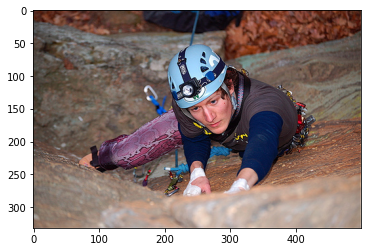

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(img_path)
plt.imshow(img)


In [ ]:
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

man in red shirt is climbing rock face


In [10]:
def caption_the_image(img):
  img_path = flicker8k_dataset + img
  photo = extract_feature_vgg16(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  # print(description)

  import matplotlib.pyplot as plt
  from PIL import Image

  img = Image.open(img_path)
  plt.imshow(img)

  #Remove startseq and endseq
  query = description
  stopwords = ['startseq','endseq']
  querywords = query.split()

  resultwords  = [word for word in querywords if word.lower() not in stopwords]
  result = ' '.join(resultwords)

  print(result)


553476096/553467096 [==============================] - 6s 0us/step
startseq woman smiling with woman smiling endseq
woman smiling with woman smiling


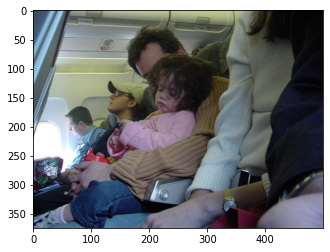

In [62]:
caption_the_image('2921094201_2ed70a7963.jpg')

startseq the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


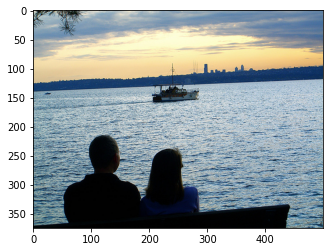

In [63]:
caption_the_image('44129946_9eeb385d77.jpg')

startseq the the the the the man on the bike bike on the rock on the rock on the mountain bike rock on rock on the mountain bike rock on rock on the
the the the the the man on the bike bike on the rock on the rock on the mountain bike rock on rock on the mountain bike rock on rock on the


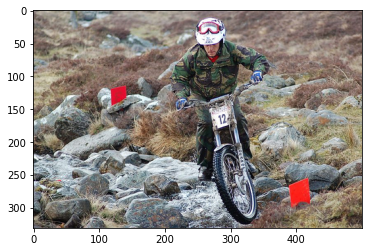

In [65]:
caption_the_image('150387174_24825cf871.jpg')

CAPTION:  group of people in an older man in an orange shirt stands in the middle of the middle of the crowd


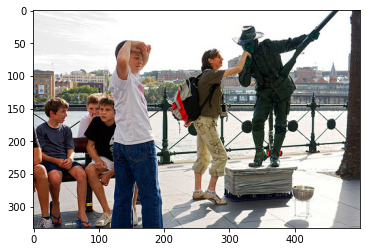

In [69]:
import matplotlib.pyplot as plt
from PIL import Image

img = '3482062809_3b694322c4.jpg'
img_path = flicker8k_dataset + img
photo = extract_feature_vgg16(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
# print(description)


img = Image.open(img_path)
plt.imshow(img)

#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print("CAPTION: ", result)

In [11]:
caption_the_image('3437147889_4cf26dd525.jpg')

553476096/553467096 [==============================] - 5s 0us/step


NameError: ignored